# Assignment 3

Matrikelnr.: 2089929

## Imports

In [1404]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter
import matplotlib as mpl
from sklearn.metrics import silhouette_score
import warnings
from scipy.stats._mstats_basic import winsorize
warnings.filterwarnings("ignore")

## Überblick und Vorbereitung der Daten

In [1405]:
df_social = pd.read_csv('03_Clustering_Marketing.csv',delimiter=';')
df_social.describe()

,gradyear,NumberOffriends,basketball,football,soccer,softball,volleyball,swimming,cheerleading,baseball,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.00000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,...,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,2007.496933,29.834533,0.267000,0.255467,0.22200,0.159667,0.142933,0.135000,0.105133,0.104133,...,0.112867,0.259467,0.357267,0.150267,0.071800,0.051467,0.185867,0.118067,0.091733,0.061067
std,1.116516,35.386649,0.788851,0.702260,0.92042,0.737344,0.638747,0.548691,0.502491,0.519205,...,2.708619,0.704398,0.728512,0.478716,0.356258,0.280755,0.609928,0.455200,0.420631,0.349112
min,2006.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2006.000000,3.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2008.000000,20.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2008.000000,44.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2009.000000,605.000000,22.000000,9.000000,22.00000,17.000000,14.000000,31.000000,8.000000,14.000000,...,327.000000,12.000000,11.000000,8.000000,8.000000,8.000000,16.000000,14.000000,8.000000,16.000000


Der Datensatz umfasst 15.000 Zeilen und 40 Spalten. Er enthält eine Mischung aus numerischen und kategorialen Variablen, darunter das Abschlussjahr (gradyear), Geschlecht (gender), Alter (age), die Anzahl der Freunde (NumberOffriends) sowie eine Vielzahl von Angaben zu Interessen und Aktivitäten wie Basketball, Fußball, Schwimmen und persönliche Vorlieben wie Musik und Einkaufen.

Die Abschlussjahre im Datensatz reichen von 2006 bis 2009. Das Alter der Personen variiert, wobei einige Werte fehlen. Die Anzahl der Freunde pro Person reicht von 0 bis 605, mit einem Durchschnittswert von etwa 30 Freunden. Neben diesen demografischen Informationen enthält der Datensatz Angaben zu verschiedenen Aktivitäten und Vorlieben in Form von booleschen Werten.

### Datentypen berichtigen

In [1406]:
df_social['age'] = pd.to_numeric(df_social['age'], errors='coerce')

### Nullwerte entfernen

In [1407]:
df_social = df_social.dropna()

### Ausreißer entfernen

<Axes: xlabel='age', ylabel='Count'>

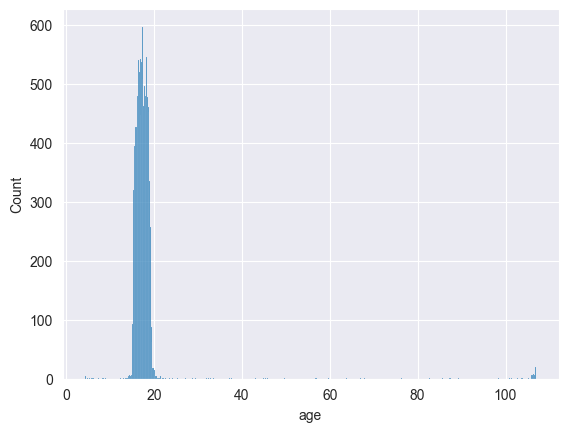

In [1408]:
sns.histplot(df_social['age'])

Wir sehen, dass der allergrößte Teil der Nutzer sich in der Alterklasse von 15-20 Jahren befindet. Es gibt allerdings immer wieder Datenpunkte in anderen Altersklassen bis hin zu 100 Jahren. Wir wenden Winsorizing an, um diese Ausreißer zu entfernen und eine in etwa normalverteilte Menge zu erhalten. 

<Axes: xlabel='age', ylabel='Count'>

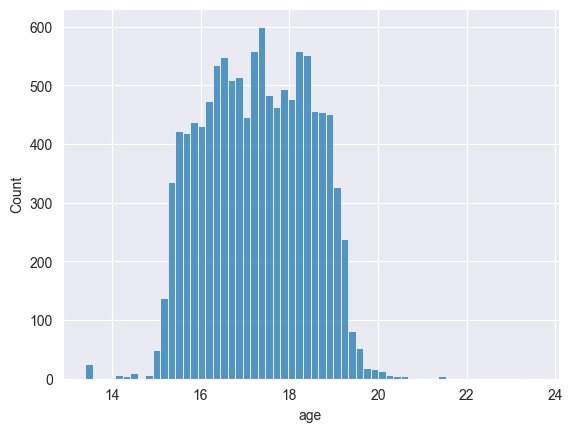

In [1409]:
df_social['age'] = winsorize(df_social['age'], limits=[0.002, 0.01])
df_social = df_social[df_social['age'] <= 24]
sns.histplot(df_social['age'])

<Axes: xlabel='NumberOffriends', ylabel='Count'>

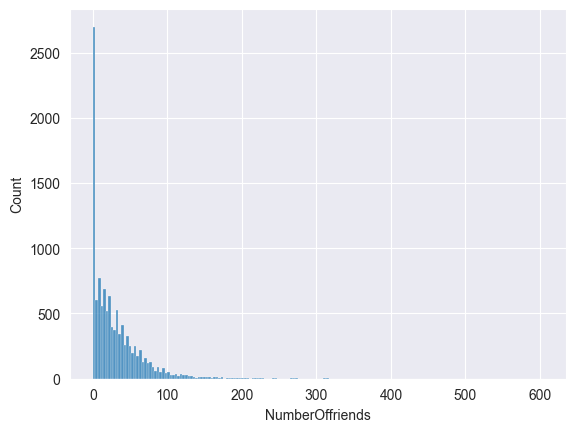

In [1410]:
sns.histplot(df_social['NumberOffriends'])

Eine ähnliche Problematik sehen wir auch bei der Anzahl der Freunden, weshalb wir hier auch Winsorizing durchführen. Eine Normalverteilung ist hier allerdings nicht erreichbar, weil viele Nutzer eine leere Freundesliste haben. Diese werden wir auch nicht entfernen, da dies die Natur der Daten zu sehr verändern würde und diese Nutzer trotzdem aus Marketingperspektive relevant sein können.

<Axes: xlabel='NumberOffriends', ylabel='Count'>

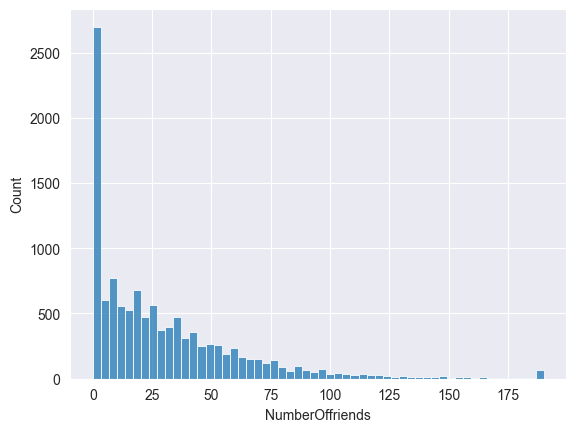

In [1411]:
df_social['NumberOffriends'] = winsorize(df_social['NumberOffriends'], limits=[0.001, 0.005])
sns.histplot(df_social['NumberOffriends'])

Auf eine Feature Extraction wird bewusst verzichtet, da sich mit kategorisierten Daten weniger gut Cluster bilden lassen.

### Prüfen von Ungleichgewichten

<Axes: xlabel='gender', ylabel='Count'>

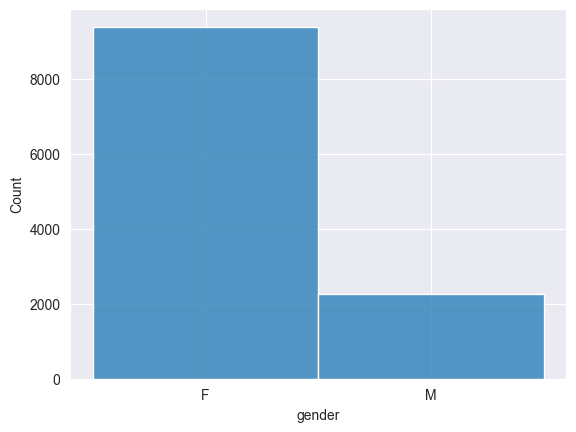

In [1412]:
sns.histplot(df_social['gender'])

Wir sehen ein starkes Ungleichgewicht in Richtung des weiblichen Geschlechts. Da wir genug Datensätze haben, wenden wir ein undersampling asn und passen die Zahl weiblicher Klassen an die Zahl männlicher Klassen an.

In [1413]:
# Dataframe aufteilen nach Geschlecht
df_social_m = df_social[df_social['gender'] == 'M']
df_social_f = df_social[df_social['gender'] == 'F']

# Die unterrepräsentierte Klasse identifizieren
undersample_size = min(len(df_social_m), len(df_social_f))

# Beide Dataframes nach der Größe der kleineren Klasse resamplen
df_social_m_under = df_social_m.sample(undersample_size, random_state=42)
df_social_f_under = df_social_f.sample(undersample_size, random_state=42)

# Beide Dataframes wieder kombinieren
df_social = pd.concat([df_social_m_under, df_social_f_under])

<Axes: xlabel='gender', ylabel='Count'>

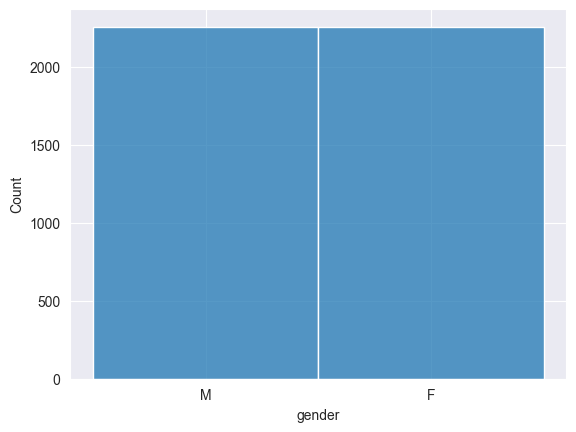

In [1414]:
sns.histplot(df_social['gender'])

### Encoding

In [1415]:
df_social.head()

,gradyear,gender,age,NumberOffriends,basketball,football,soccer,softball,volleyball,swimming,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
3764,2008,M,17.076,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,1
2949,2009,M,16.096,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10106,2008,M,16.482,15,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9093,2007,M,17.903,30,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1627,2008,M,16.337,8,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [1416]:
# Nicht-numerische Spalten identifizieren
non_numeric_columns = df_social.select_dtypes(include=['object', 'category']).columns

# Alle nicht-numerischen Spalten encoden
for col in non_numeric_columns:
    unique_values = df_social[col].unique()
    df_social[col] = df_social[col].replace(to_replace=unique_values, value=list(range(len(unique_values))))
    
df_social.head()

,gradyear,gender,age,NumberOffriends,basketball,football,soccer,softball,volleyball,swimming,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
3764,2008,0,17.076,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,1
2949,2009,0,16.096,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10106,2008,0,16.482,15,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9093,2007,0,17.903,30,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1627,2008,0,16.337,8,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


## Aufgabe 01
Cluster the existing data based on appropriate procedures. Justify how you would cluster the data set based on the results.
Im nachfolgenden haben wir uns ein paar Cluster ausgesucht, die wir genauer betrachten möchten.

In [1417]:
# Erstellen eines Standardskalierers
scaler = StandardScaler()
# Age vs number of friends
df_age_number_of_friends = scaler.fit_transform(df_social[['age', 'NumberOffriends']])
# Gender vs number of friends
df_gender_number_of_friends = scaler.fit_transform(df_social[['gender', 'NumberOffriends']])
# Age vs basketball
df_age_basketball = scaler.fit_transform(df_social[['age', 'basketball']])
# Age vs football
df_age_football = scaler.fit_transform(df_social[['age', 'football']])
# Basketball vs football
df_basketball_football = scaler.fit_transform(df_social[['basketball', 'football']])
# Gender vs cheerleading
df_gender_cheerleading = scaler.fit_transform(df_social[['gender', 'cheerleading']])
# Lifestyle vs religion
df_social['lifestyle'] = df_social[['sex', 'sexy', 'cute', 'kissed']].sum(axis=1)
df_social['religion'] = df_social[['god', 'church', 'jesus', 'bible']].sum(axis=1)
df_lifestyle_religion = scaler.fit_transform(df_social[['lifestyle', 'religion']])
# Lifestyle vs consumption
df_social['consumption'] = df_social[['mall', 'shopping', 'clothes', 'abercrombie', 'hollister']].sum(axis=1)
df_lifestyle_consumption = scaler.fit_transform(df_social[['lifestyle', 'consumption']])
# Consumption vs religion
df_consumption_religion = scaler.fit_transform(df_social[['consumption', 'religion']])

Jedes Cluster wurde aufgrund der Kombination und Intensität bestimmter Merkmale gebildet: 

- Alter vs. Anzahl der Freunde: Dieses Cluster kann aufzeigen, wie soziale Interaktionen mit dem Alter zusammenhängen, was für altersgerechtes Marketing nützlich ist. 
- Geschlecht vs. Anzahl der Freunde: Hier kann analysiert werden, ob und wie soziale Netzwerke geschlechtsspezifisch genutzt werden, was geschlechterorientierte Marketingstrategien unterstützen könnte. 
- Alter vs. Basketball: Dies könnte Aufschluss darüber geben, in welchem Alter Basketball besonders beliebt ist, um gezielte Sportprogramme oder -produkte zu bewerben. 
- Alter vs. Fußball: Ähnlich wie beim Basketball könnte dies Trends in der Beliebtheit von Fußball in verschiedenen Altersgruppen aufzeigen. 
- Basketball vs. Fußball: Die Gegenüberstellung dieser beiden Sportarten kann helfen zu verstehen, welche der beiden Sportarten dominiert und wie sich Interessen überschneiden. 
- Geschlecht vs. Cheerleading: Dieses Cluster kann geschlechtsspezifische Vorlieben für Cheerleading verdeutlichen, was für die Ausrichtung von Angeboten oder Programmen relevant sein kann. 
- Lifestyle vs. Religion: Die Beziehung zwischen Lifestyle-Indikatoren und Religiosität kann Einblick in die Wertvorstellungen der Nutzer geben, was für ethisch ausgerichtetes Marketing wichtig sein könnte. 
- Lifestyle vs. Konsum: Dieses Cluster hilft zu verstehen, wie Lifestyle-Präferenzen Konsumverhalten beeinflussen, um zielgerichtete Werbemaßnahmen zu entwickeln. 
- Konsum vs. Religion: Mit diesem Cluster wollen wir verstehen, ob es Schnittmengen zwischen konsum-orientierten Nutzern und religösen Nutzern gibt.

## Aufgabe 02
Cluster the existing data based on appropriate procedures. Justify how you would cluster the data set based on the results.

Zuerst führen wir die Ellenbogen und die Silhouette-Methode durch, um eine Idee für die Anzahl an Clustern zu bekommen. Um Code Zeilen zu sparen, definieren wir hierfür Funktionen.

In [1418]:
# Diese Funktion visualisiert die Elbow-Methode zur Bestimmung der optimalen Anzahl von Clustern.
def create_elbow_plot(data, width, height):
    df_norm = (data - data.mean()) / data.std()
    ssd = [KMeans(n_clusters=k, random_state=0).fit(df_norm).inertia_ for k in range(1, 10)]
    plt.figure(figsize=(width, height))
    plt.plot(range(1, 10), ssd, 'bx-')
    plt.xlabel('Anzahl der Cluster (K)')
    plt.ylabel('Summe der quadrierten Abstände (SSD)')
    plt.title('Elbow-Methode')
    plt.show()
    
# Diese Funktion erstellt einen PairPlot zur Visualisierung von Clustern in einem DataFrame.
def create_pair_plot(df_Imput, x_vars, y_vars, height_, k_clusters):
    kmeans_ = KMeans(n_clusters=k_clusters, random_state=42)
    y_pred = kmeans_.fit_predict(df_Imput)
    df_social['Cluster_chache'] = kmeans_.labels_
    scaler = StandardScaler()
    sns.pairplot(data=df_social, x_vars=[x_vars], y_vars=[y_vars], hue="Cluster_chache", height=height_, palette='bright')
    
def create_silhouette_diagram(df, k_options):
    n_rows = len(k_options) // 2 + len(k_options) % 2
    plt.figure(figsize=(11, n_rows * 4.5))
    kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(df) for k in range(1, max(k_options) + 1)]
    silhouette_scores = [silhouette_score(df, model.labels_) for model in kmeans_per_k[1:]]
    
    for i, k in enumerate(k_options, start=1):
        plt.subplot(n_rows, 2, i)
        
        y_pred = kmeans_per_k[k - 1].labels_
        silhouette_coefficients = silhouette_samples(df, y_pred)

        padding = len(df) // 30
        pos = padding
        ticks = []
        for i in range(k):
            coeffs = silhouette_coefficients[y_pred == i]
            coeffs.sort()

            color = mpl.cm.Spectral(i / k)
            plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                            facecolor=color, edgecolor=color, alpha=0.7)
            ticks.append(pos + len(coeffs) // 2)
            pos += len(coeffs) + padding

        plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
        plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
        if k in (3, 5):
            plt.ylabel("Cluster")
        
        if k in (5, 6):
            plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
            plt.xlabel("Silhouette Coefficient")
        else:
            plt.tick_params(labelbottom=False)

        plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
        plt.title("$k={}$".format(k), fontsize=16)

    plt.show()

Die Funktion wird nun auf unsere Cluster angewandt.

### Gender / Number of Friends

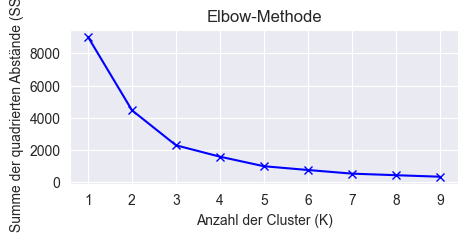

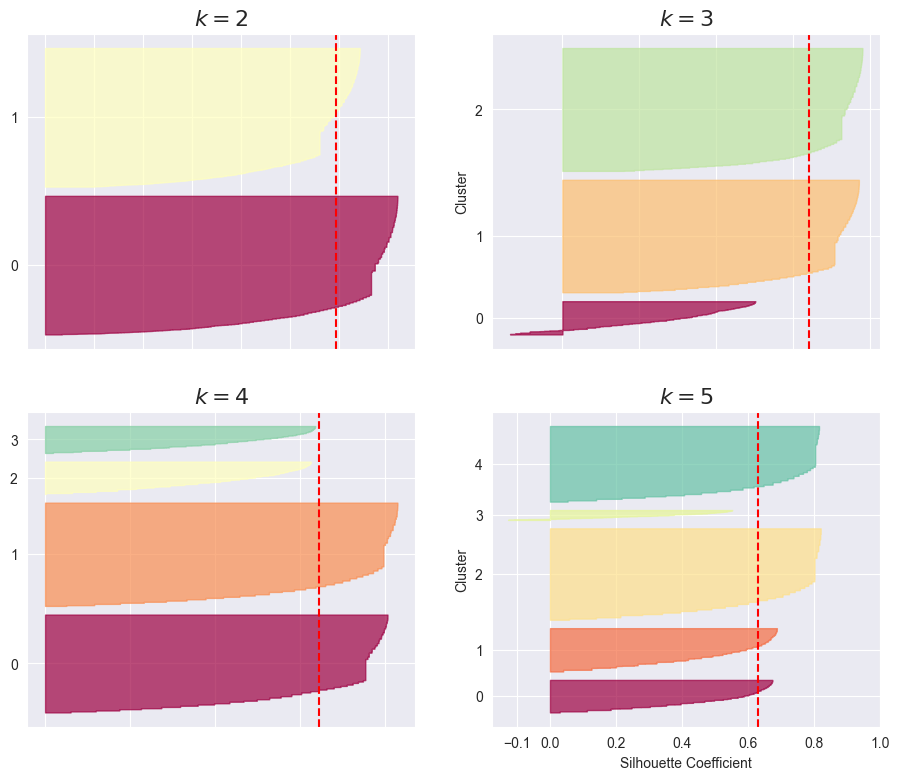

In [1419]:
create_elbow_plot(df_gender_number_of_friends, 5, 2)
create_silhouette_diagram(df_gender_number_of_friends, (2,3,4,5))

Der Elbow Plot zeigt eine optimale Clusterzahl von 3, das Silhouette Diagram zeigt jedoch, dass eine Clusterzahl von 4 besser wäre.

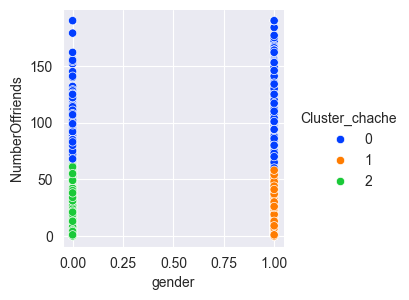

In [1420]:
create_pair_plot(df_gender_number_of_friends, 'gender', 'NumberOffriends', 3, 3)

Der Boxplot illustriert, dass es keine signifikanten Unterschiede in der Anzahl der Freunde zwischen den beiden Geschlechtern gibt, da beide Geschlechter über alle Cluster hinweg eine ähnliche Verteilung aufweisen. Die weit verteilten Datenpunkte entlang der y-Achse zeigen eine große Variabilität in der Freundesanzahl innerhalb jedes Geschlechts.

### Age / Number of Friends

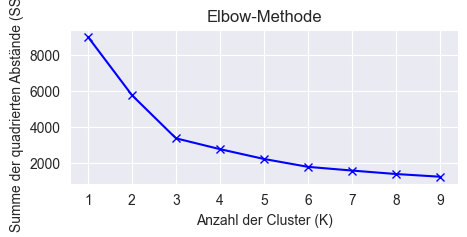

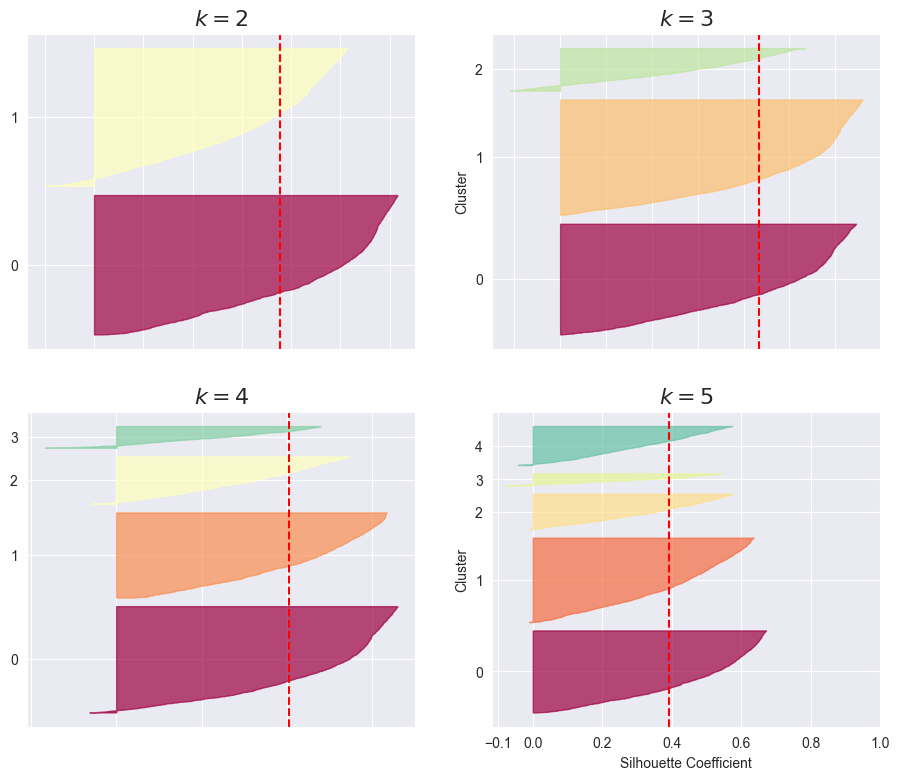

In [1421]:
create_elbow_plot(df_age_number_of_friends, 5, 2)
create_silhouette_diagram(df_age_number_of_friends, (2,3,4,5))

Der Elbow sowie der Silhouette Plot zeigt eine optimale Clusterzahl von k=3.

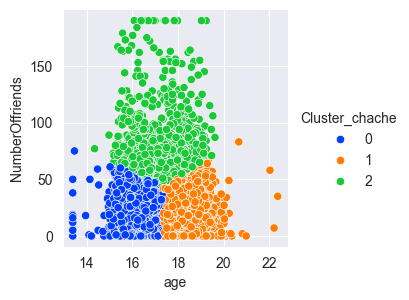

In [1422]:
create_pair_plot(df_age_number_of_friends, 'age', 'NumberOffriends', 3, 3)

Der Scatterplot zeigt, dass die Anzahl der Freunde auf der Social-Media-Plattform bei den dargestellten Altersgruppen variiert. Die jüngeren Nutzer (circa 14-16 Jahre) scheinen in Clustern mit einer geringeren Anzahl von Freunden zu sein, während die Anzahl der Freunde mit steigendem Alter bis zu einem Punkt zunimmt, ab dem sie wieder zu fallen scheint. Es gibt auch eine erkennbare Dichte von Nutzern im mittleren Altersbereich, die eine mittlere Anzahl von Freunden aufweist.

### Basketball / Football

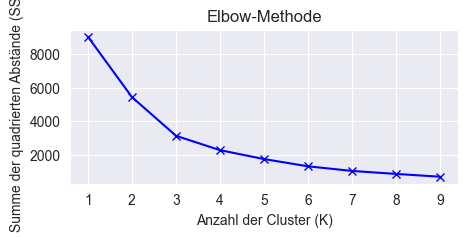

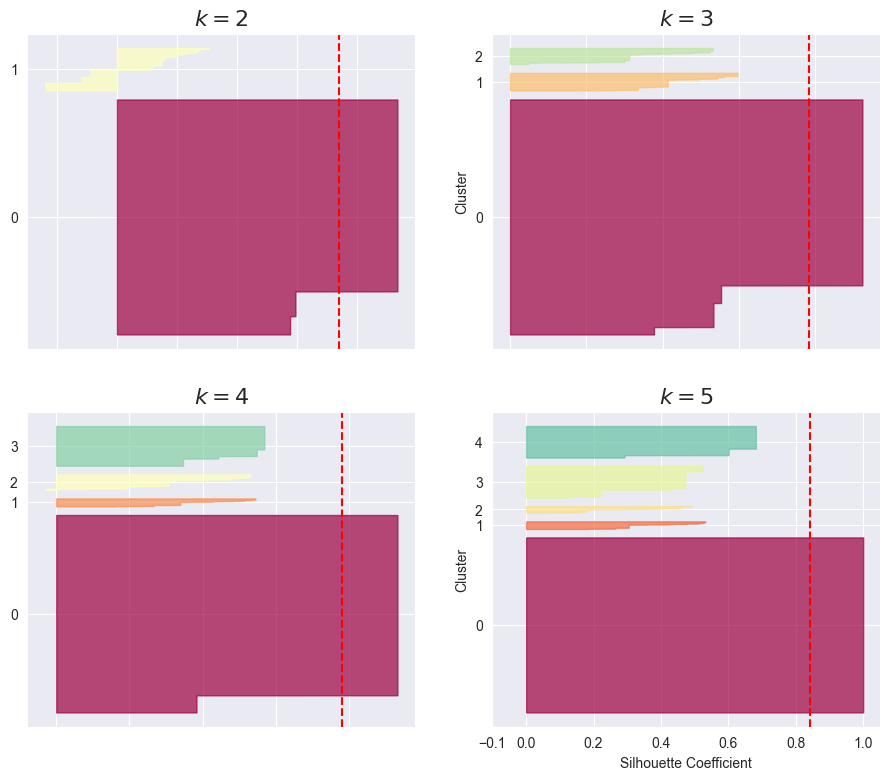

In [1423]:
create_elbow_plot(df_basketball_football, 5, 2)
create_silhouette_diagram(df_basketball_football, (2,3,4,5))

Die Elbow Methode zeigt eine optimale Clusterzahl von 3, das Silhouette Diagram zeigt kein eindeutiges Optimum. Wir fahren mit k=3 fort.

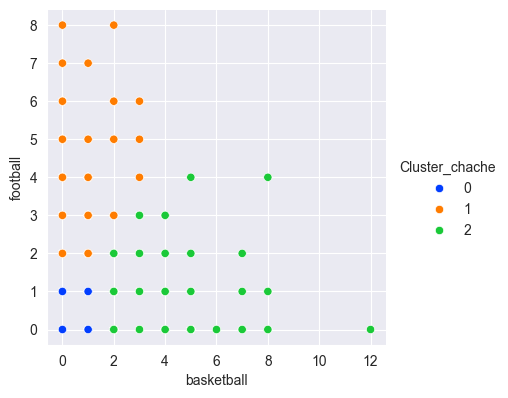

In [1424]:
create_pair_plot(df_basketball_football, 'basketball', 'football', 4, 3)

Es sind drei Cluster zu erkennen: Cluster 0 zeigt User mit geringer Häufung sowohl der Begriffe Basketball als auch Football. In Cluster 1 finden sich Nutzer mit einer Häufung des Begriffs football. Cluster 2 zeigt User mit einer Häufung des Begriffs Basketball. Wir sehen, dass es einige Datenpunkte gibt, die zur Mitte tendieren. Bei diesen Nutzern könnte sowohl ein Interesse an Basketball als auch an Football bestehen. Es lässt sich aber leider keine eindeutige Kausalität zwischen Basketball- und Football-Fans erkennen.

### Age / Basketball

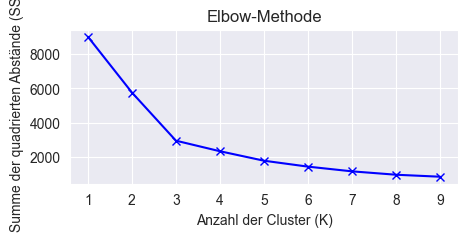

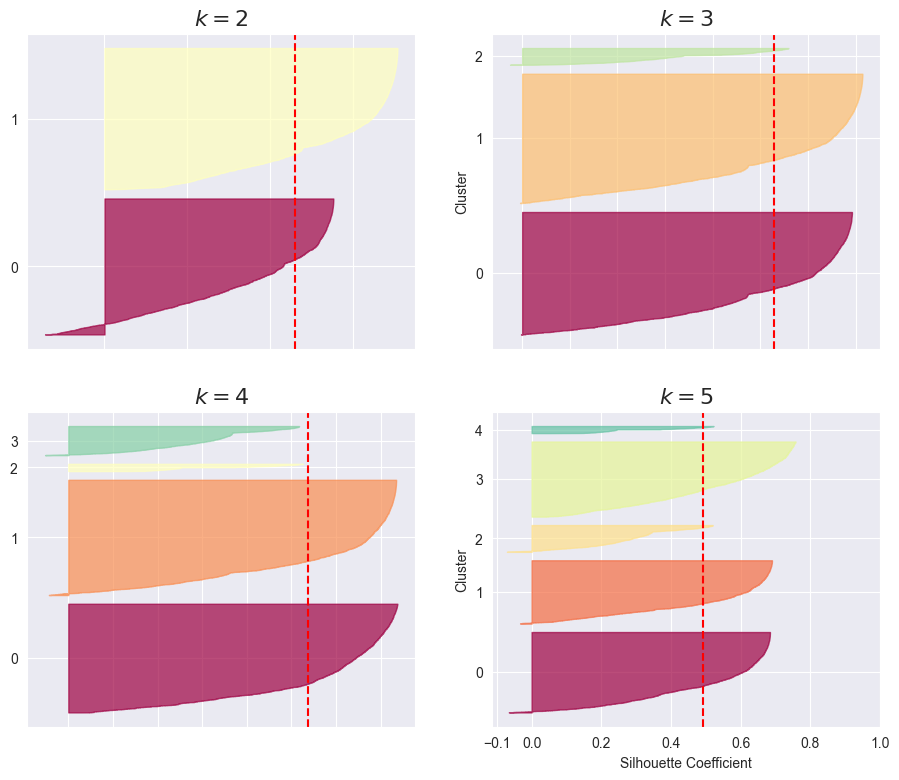

In [1425]:
create_elbow_plot(df_age_basketball, 5, 2)
create_silhouette_diagram(df_age_basketball, (2,3,4,5))

Der Elbow sowie der Silhouette Plot zeigt eine optimale Clusterzahl von k=3.

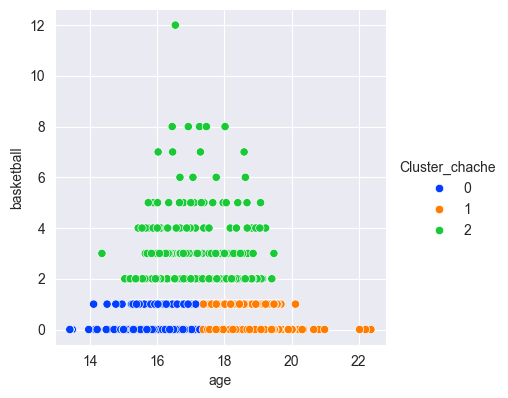

In [1426]:
create_pair_plot(df_age_basketball, 'age', 'basketball', 4, 3)

Cluster 0, das Jugendliche im Alter von 14 bis 17 Jahren umfasst, zeigt ein eher niedriges Interesse an Basketball. Cluster 1, das Altersgruppen von 15 bis 20 Jahren abdeckt, zeigt ein mittleres bis hohes Interesse, und Cluster 2, bestehend aus der Altersgruppe 18 bis 22 Jahre, zeigt wiederum ein eher niedriges Interesse. Diese Verteilung könnte darauf hindeuten, dass das Interesse an Basketball in der mittleren Altersgruppe am stärksten ausgeprägt ist.

### Age / Football

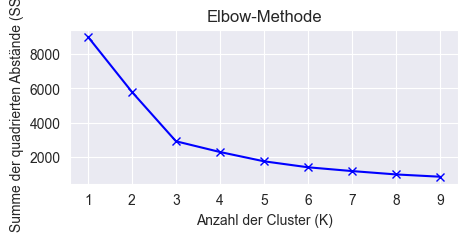

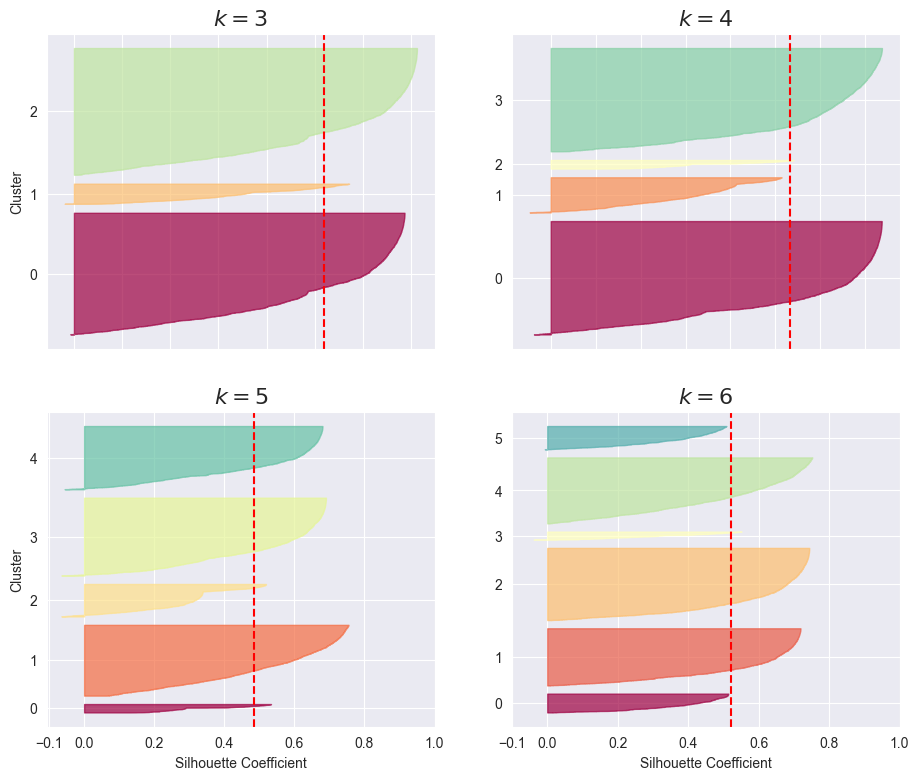

In [1427]:
create_elbow_plot(df_age_football, 5, 2)
create_silhouette_diagram(df_age_football, (3,4,5,6))

Der Elbow Plot zeigt eine optimale CLusterzahl von 3, das Silhouette Diagram zeigt ein Optimum von 4. Wir fahren mit k=4 fort.

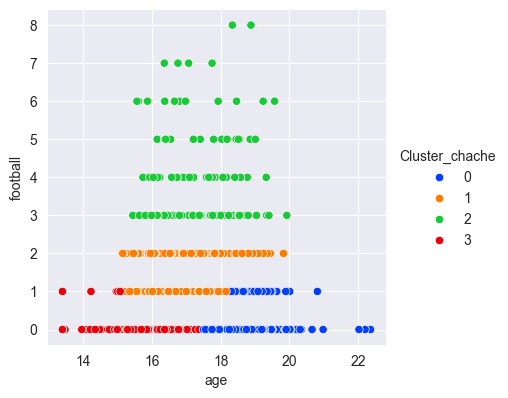

In [1428]:
create_pair_plot(df_age_football, 'age', 'football', 4, 4)

Cluster 0 (blau) zeigt eine konstant niedrige Anzahl an Nennungen von Fußball durch die Altersgruppen 17 bis 22 Jahre. Cluster 1 (rot) zeigt ein moderates Niveau des Interesses, das sich in der Altersgruppe von 14 bis etwa 18 konzentriert. Cluster 2 (orange) zeigt eine hohe Anzahl an Nennungen von Fußball, hauptsächlich in der Altersgruppe von 15 bis 17 Jahren. Cluster 3 (grün) zeigt eine breite Verteilung mit tendenziell höherem Interesse, das sich vor allem in den Altersgruppen von 17 bis 19 Jahren zeigt.

### Gender / Cheerleading

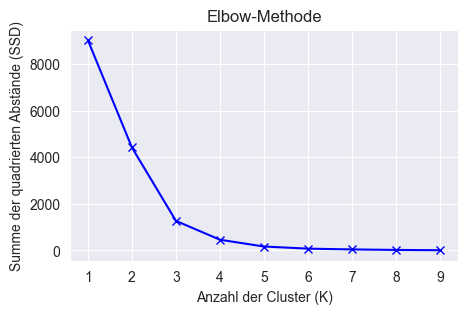

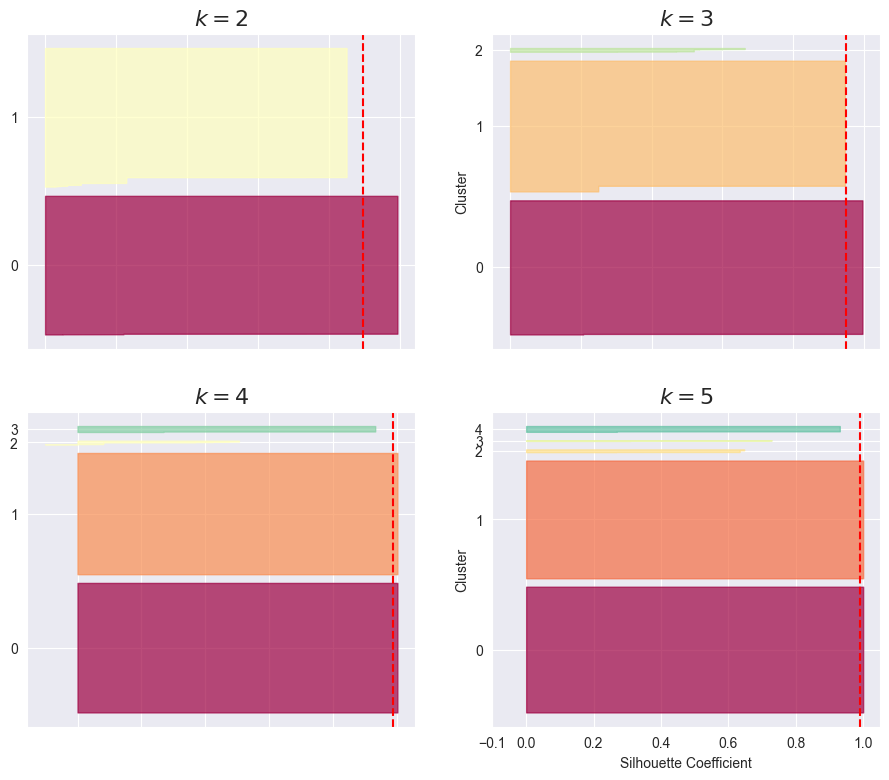

In [1429]:
create_elbow_plot(df_gender_cheerleading, 5, 3)
create_silhouette_diagram(df_gender_cheerleading, (2,3,4,5))

Sowohl Elbow Plot als auch Silhouette Plot zeigen ein Optimum von k=3.

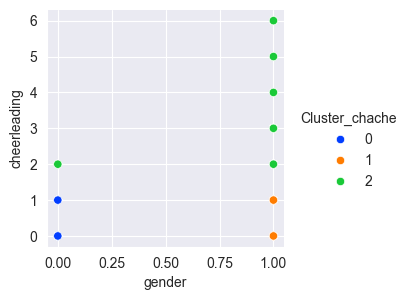

In [1430]:
create_pair_plot(df_gender_cheerleading, 'gender', 'cheerleading',3,3)

Wir sehen drei Cluster: Cluster 0 zeigt männliche Nutzer mit geringem Interesse an Cheerleading. Cluster 1 zeigt weibliche Nutzer mit geringem Interesse an Cheerleading. Cluster 2 (grün) zeigt Nutzer mit mittlerem bis hohem Interesse an Cheerleading. Wir sehen eine deutliche Häufung der Datenpunkte von Cluster 2 bei den weiblichen Nutzern.

### Lifestyle / Religion

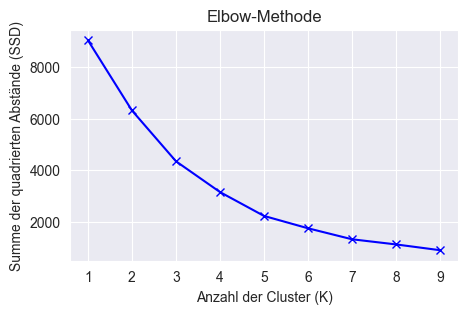

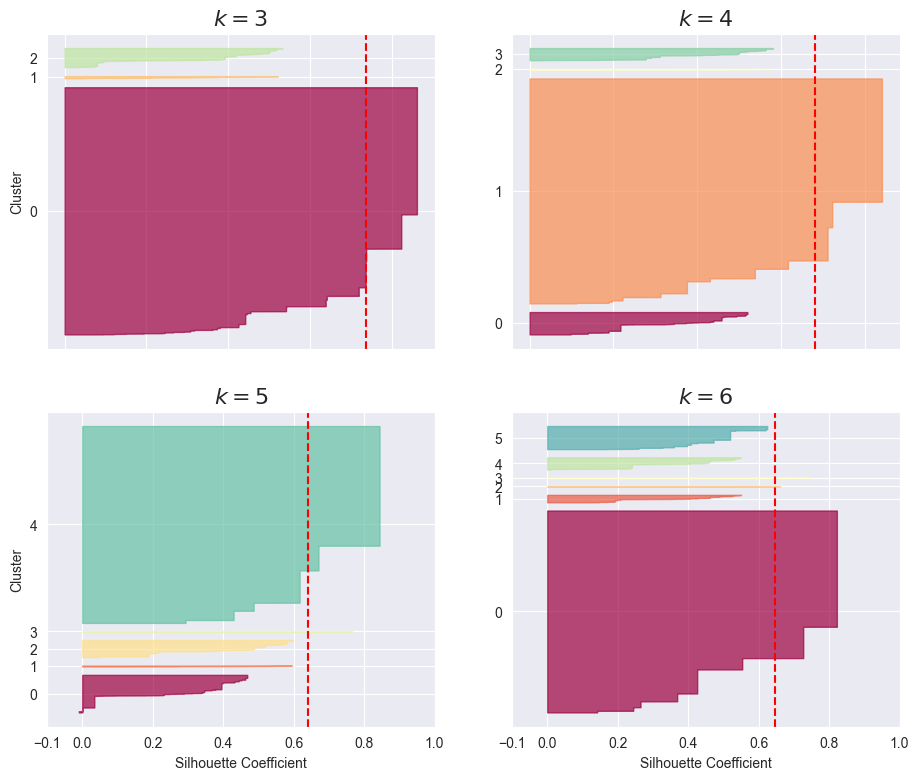

In [1431]:
create_elbow_plot(df_lifestyle_religion, 5, 3)
create_silhouette_diagram(df_lifestyle_religion, (3,4,5,6))

Eine eindeutige optimale Clusterzahl ist aus dem Elbow Plot nicht abzulesen, befindet sich aber wahrscheinlich im Bereich von 3 oder 4. Der Silhouette Plot zeigt, dass k=4 optimal ist.

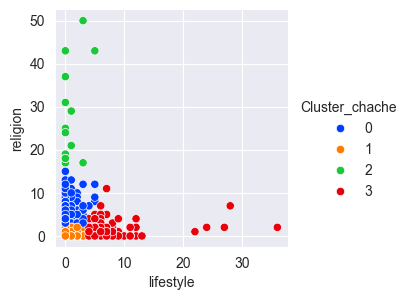

In [1432]:
create_pair_plot(df_lifestyle_religion, 'lifestyle', 'religion',3,4)

Wir sehen vier verschiedene Cluster. Cluster 1 zeigt Nutzer, in dessen Profilen sowohl keine Lifestlyle-orientierten Begriffe als auch keine religiösen Begriffe vorkommen. Cluster 0 (blau) zeigt Nutzer mit einer mittleren Anzahl an religiösen Begriffen. Cluster 2 (grün) zeigt die Nutzer, welche viele religiöse Begriffe in ihren Profilen stehen haben. Und Cluster 3 (rot) zeigt Nutzer mit einer mittleren bis hohen Anzahl an lifestyle-orientierten Begriffen. Interessant ist, dass es kaum Datenpunkte in der Mitte gibt. Das bedeutet, dass die eine Häufung von religiösen Begriffen in den allermeisten Fällen auch nicht mit einer Nennung von lifestyle-orientierten Worten in den Profilen einhergeht.

### Lifestyle / Consumption

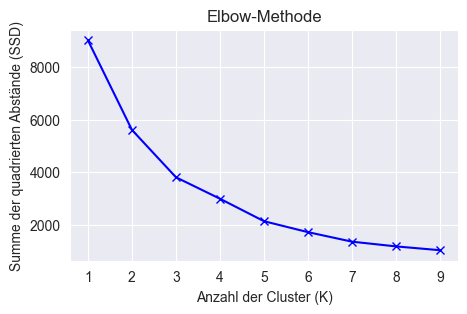

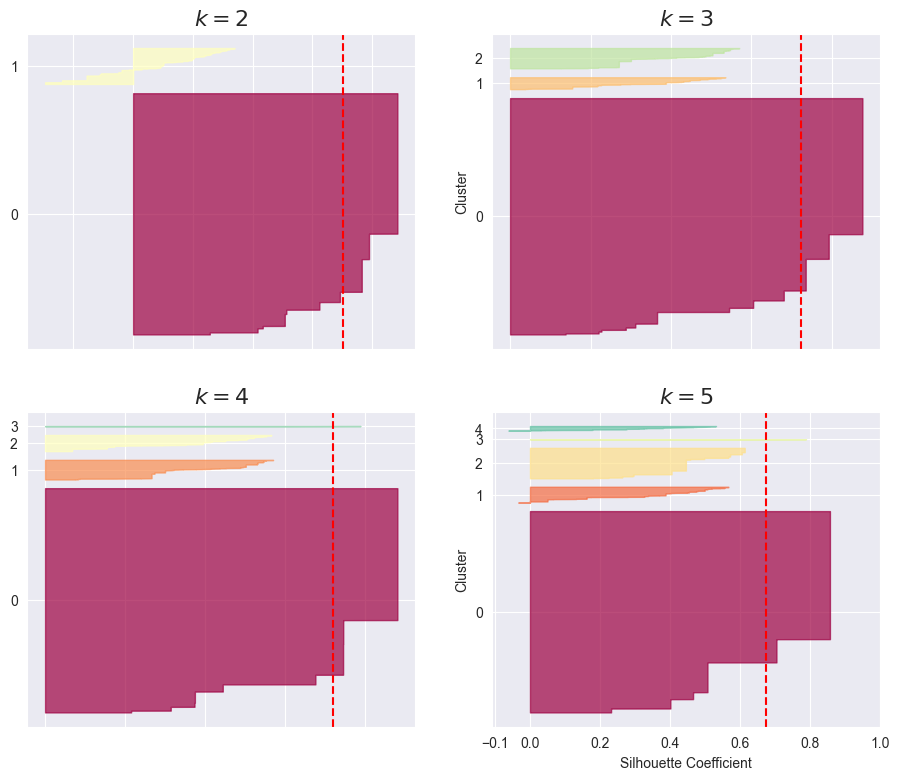

In [1433]:
create_elbow_plot(df_lifestyle_consumption, 5, 3)
create_silhouette_diagram(df_lifestyle_consumption, (2,3,4,5))

Elbow- und Silhouette Plot zeigen k=3 als Optimum.

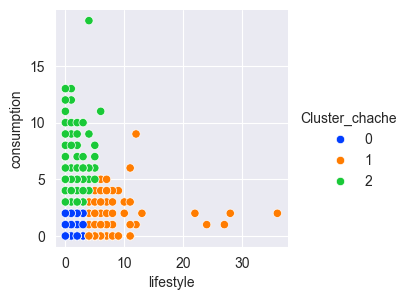

In [1434]:
create_pair_plot(df_lifestyle_consumption, 'lifestyle', 'consumption',3,3)

Cluster 0 (blau) zeigt Nutzer mit niedrigen Werten in beiden Dimensionen, was auf eine geringe Neigung zu den erfassten Lifestyle- und Konsumaktivitäten hinweist. Cluster 1 (grün) zeigt eine mittlere bis hohe Neigung zum Konsum, aber mit niedrigeren Lifestyle-Werten. Cluster 2 (orange) zeigt eine hohe Neigung sowohl zu Lifestyle-Aktivitäten als auch zu Konsum, wobei diese Gruppe am stärksten in Lifestyle-Aktivitäten engagiert zu sein scheint.

### Consumption / Religion

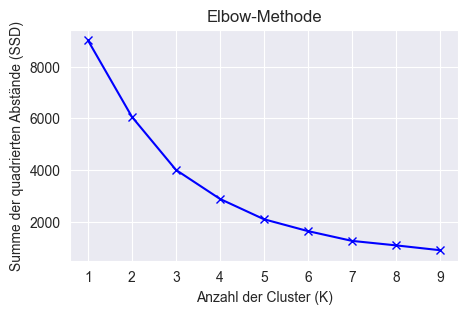

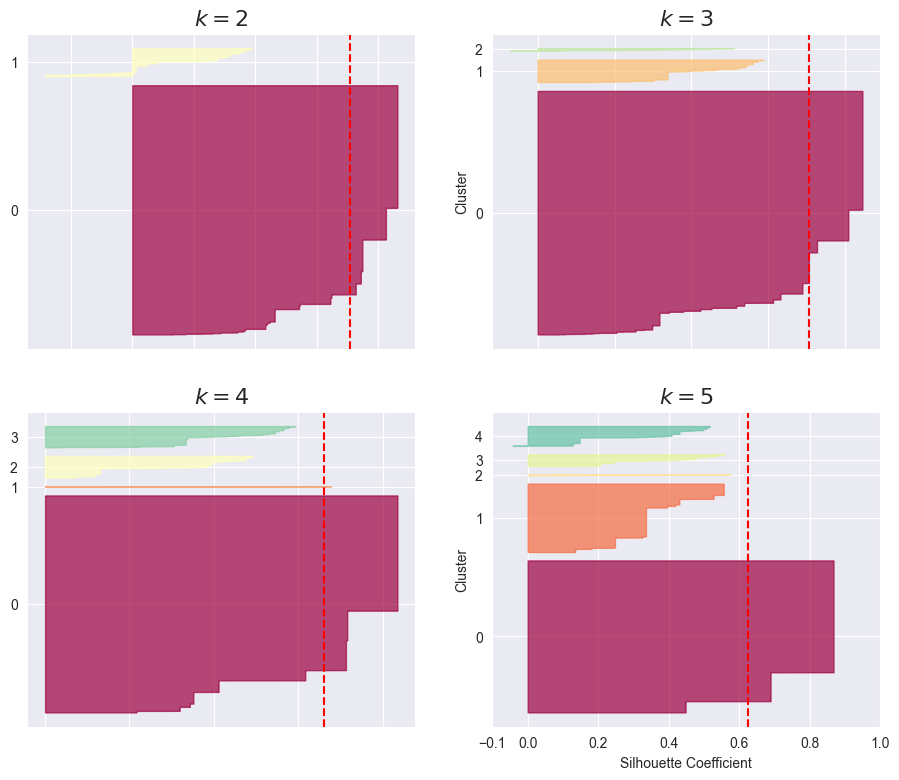

In [1435]:
create_elbow_plot(df_consumption_religion, 5, 3)
create_silhouette_diagram(df_consumption_religion, (2,3,4,5))

Anhand des Silhouette Plots sehen wir ein Optimum von k=4.

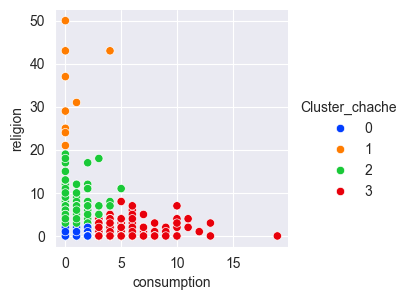

In [1438]:
create_pair_plot(df_consumption_religion, 'consumption', 'religion', 3, 4)

Wir sehen vier verschiedene Cluster, welche von der Verteilung her ähnlich aussehen wie im Plot von Religion und Lifestyle. Wir haben ein kleineres Cluster (0, blau) mit Nutzern, welche keine Aktivität in beiden Kategorien zeigen. Dann haben wir zwei Cluster mit mittel bis hohen Aktivitäten im religiösen Bereich (Cluster 1, orange und 2, grün). Cluster 3 (rot) zeigt eher konsum-orientierte Profile. Bemerkenswert ist hier, dass auch hier die Interessen relativ klar getrennt sind und es wenig Überschneidungen in der Mitte gibt.

## Aufgabe 03
What recommendation could you give the marketing department based on your analysis?

Nach Aufstellen und Analysieren der Cluster lässt sich folgendes festhalten:  
- Es ließen sich keine signifikanten Zusammenhänge zwischen dem Geschlecht der Nutzer und der Anzahl an Freunden feststellen. Das Geschlecht sollte also bei der Frage, wie sich eine Marketing-Kampagnen durch einen Freundeskreis verbreitet, keine große Rolle spielen. 
- Das größte Potential für die Nutzung von Netzwerkeffekten durch größere Freundeskreise gibt es in der Altersklasse von 15 bis 20 Jahren. Ältere und jüngere Nutzer tendieren eher dazu, kleinere Freundeskreise zu haben. Hier ist jedoch auf die Verteilung der Altersklassen im Datensatz hinzuweisen. Eine größere Streuung der Altersgruppen könnte dieses Ergebnis nochmal verändern.
- Es konnten keine größeren Schnittmengen zwischen Basketball- und Fußballfans ermittelt werden. Kampagnen mit Sportfokus sollten deshalb eher gezielt die einzelnen Lager der Sportarten ansprechen und nicht auf Synergieffekte setzen.
- Bei Kampagnen mit Cheerleading-Content sollten vorzugsweise an weibliche Nutzer ausgespielt werden.
- Es lässt sich eine relativ deutliche Trennung zwischen Nutzern mit Vorliebe für lifestyle- sowie konsumorientierte Aktivitäten sowie Nutzern mit religiösem Fokus erkennen. Diese Nutzergruppen sollten in Kampagnen separat angesprochen werden.
- Kampagnen mit Fokus auf Konsum (also z.B. Shopping) können auch an Nutzergruppen ausgespielt werden, die lifestyle-orientiert leben, weil hier Schnittmengen vorhanden sind.